In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from PenultimateFRP import CopolymerizationModel
%load_ext autoreload
%autoreload 2

# Define the full model function
def model(t, kd, f, kpAA, kpAB, kpBA, kpBB, 
     kdAA, kdAB, kdBA, kdBB,
     ktcAA, ktcAB, ktcBB,
     ktdAA, ktdAB, ktdBB): 
    k = [kd, f, 
     kpAA, kpAB, kpBA, kpBB, 
     kdAA, kdAB, kdBA, kdBB,
     ktcAA, ktcAB, ktcBB,
     ktdAA, ktdAB, ktdBB]
    
    
    # M0 = [0.05, 0.1, 0.5, 1, 2]
    # I0 = [0.001, 0.005, 0.01]
    # fA = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    y0[2] = 2.1 # 70%
    y0[3] = 0.9 # 30%
    cm1 = CopolymerizationModel(k, y0, t_span)
    
    y0[2] = 1.5
    y0[3] = 1.5
    cm2 = CopolymerizationModel(k, y0, t_span)
    
    y0[2] = 0.9
    y0[3] = 2.1
    cm3 = CopolymerizationModel(k, y0, t_span)
    
    # Up to 6? different data sets --> info on the timing (e.g., 3 takes 3 minutes, 6 takes 10 minutes)
    # 
    
    fit_data = np.concatenate((cm1.A, cm2.A, cm3.A, cm1.B, cm2.B, cm3.B))
    return fit_data

# Modified function factory
def create_wrapper(model_func, fixed_params, initial_guesses):
    fit_params = [p for p in initial_guesses if p not in fixed_params]
    fit_guesses = [initial_guesses[p] for p in fit_params]

    bounds = {}
    for key, value in zip(fit_params, fit_guesses):
        bounds[key] = (0, 1e3 * value)
    
    keys = list(bounds.keys())
    values = list(bounds.values())

    #Initialize lower bounds and upper bounds lists
    lower_bounds = [bound[0] for bound in values]
    upper_bounds = [bound[1] for bound in values]

    # Convert the lists to tuples
    fit_bounds = (lower_bounds, upper_bounds)

    def fit_func(x, *args):
        params = {key: value for key, value in zip(fit_params, args)}
        params.update(fixed_params)
        #print(params)
        return model_func(x, **params)
    
    return fit_func, fit_guesses, fit_bounds

# Example usage:


In [2]:
# Initiation rate constant
kd    = 3e-06 
f     = 0.5

# Propagation rate constants
kpAA = 2.0e+04
kpAB = 5.0e+04
kpBA = 4.0e+02
kpBB = 8.0e+02

# Depropagation rate constants
kdAA = 0
kdAB = 0
kdBA = 0
kdBB = 0
kdf = 0.5
# kdAA = kdf*kpAA
# kdAB = kdf*kpAB
# kdBA = kdf*kpBA
kdBB = kdf*kpBB

# Termination by combination rate constants
# ktcAA = 2*1.5e+08
# ktcAB = 2*5.0e+07
# ktcBB = 2*1.5e+07
ktcAA = 0
ktcAB = 0
ktcBB = 0

# Termination by disproportionation rate constants
ktdAA = 2*9.0e+06     
ktdAB = 2*1.5e+07
ktdBB = 2*2.0e+07

k_params = {
     'kd': kd, 'f': f,
     'kpAA': kpAA, 'kpAB': kpAB, 'kpBA': kpBA, 'kpBB': kpBB,
     'kdAA': kdAA, 'kdAB': kdAB, 'kdBA': kdBA, 'kdBB': kdBB,
     'ktcAA': ktcAA, 'ktcAB': ktcAB, 'ktcBB': ktcBB,
     'ktdAA': ktdAA, 'ktdAB': ktdAB, 'ktdBB': ktdBB
}

In [3]:
# Data for fitting
num_points = 40
t_span = [0, 60*3600]
t = np.linspace(t_span[0], t_span[1], num_points)
t = np.concatenate((t, t, t, t, t, t))


y0 = np.zeros(33)
y0[0] = 0.005
y0[2] = 2.1
y0[3] = 0.9

In [4]:
y = model(t, **k_params)
rng = np.random.default_rng()
y_noise = 0.05 * rng.normal(size=t.size)
y_exp = y + y_noise

/Users/devoncallan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/integrate/_ivp/common.py:346: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/Users/devoncallan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/integrate/_ivp/common.py:315: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/Users/devoncallan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/integrate/_ivp/common.py:345: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/devoncallan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/integrate/_ivp/common.py:367: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


In [5]:
# Initial guesses for all parameters
initial_guesses = k_params.copy()
initial_guesses['kpAA'] = 1e1
initial_guesses['kpAB'] = 1e1
initial_guesses['kpBA'] = 1e1
initial_guesses['kpBB'] = 1e1
initial_guesses['kdBB'] = 1e1
initial_guesses['ktdAA'] = 1e6
initial_guesses['ktdBB'] = 1e6

# Parameters to keep constant (e.g., b=1.3)
fixed_params = {'kd': kd, 'f': f, 'kdAA': kdAA, 'kdAB': kdAB, 'kdBA': kdBA, 'ktcAA': ktcAA, 'ktcAB': ktcAB, 'ktcBB': ktcBB, 'ktdAB':ktdAB}

fit_params = [p for p in initial_guesses if p not in fixed_params]
adjusted_guesses = [initial_guesses[p] for p in fit_params]
#print(unfixed_params)
print(adjusted_guesses)

[10.0, 10.0, 10.0, 10.0, 10.0, 1000000.0, 1000000.0]


In [6]:
#Create wrapper function and adjusted guesses
wrapper_function, fit_guesses, fit_bounds = create_wrapper(model, fixed_params, initial_guesses)

#Fit the model using the wrapper function
params, cov = curve_fit(wrapper_function, t, y_exp, p0=fit_guesses, bounds=fit_bounds)

final_params = {}
counter = 0

for key in k_params:
    if key in fixed_params:
        final_params[key] = fixed_params[key]
        continue
    else:
        final_params[key] = params[counter]
        counter += 1

print(final_params)

{'kd': 3e-06, 'f': 0.5, 'kpAA': 3857.8552823682485, 'kpAB': 9724.206539680054, 'kpBA': 219.29497009448272, 'kpBB': 243.39061585457995, 'kdAA': 0, 'kdAB': 0, 'kdBA': 0, 'kdBB': 3.903118906527665, 'ktcAA': 0, 'ktcAB': 0, 'ktcBB': 0, 'ktdAA': 795901.7660761469, 'ktdAB': 30000000.0, 'ktdBB': 8552752.40019323}


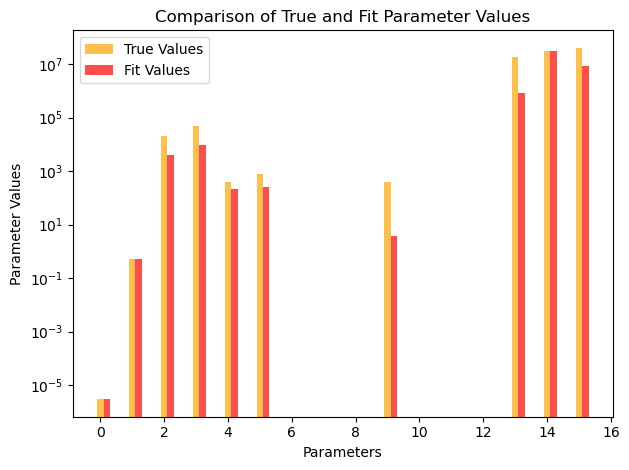

In [8]:
bar_width = 0.2
index = np.arange(len(k_params))

# Plot the true values (in blue) and the optimized values (in red)
plt.bar(index, k_params.values(), bar_width, label='True Values', color='orange', alpha=0.7)
plt.bar(index + bar_width, final_params.values(), bar_width, label='Fit Values', color='red', alpha=0.7)
plt.yscale("log")
# plt.ylim(top=5e4)

# Customize the plot
plt.xlabel('Parameters')
plt.ylabel('Parameter Values')
plt.title('Comparison of True and Fit Parameter Values')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

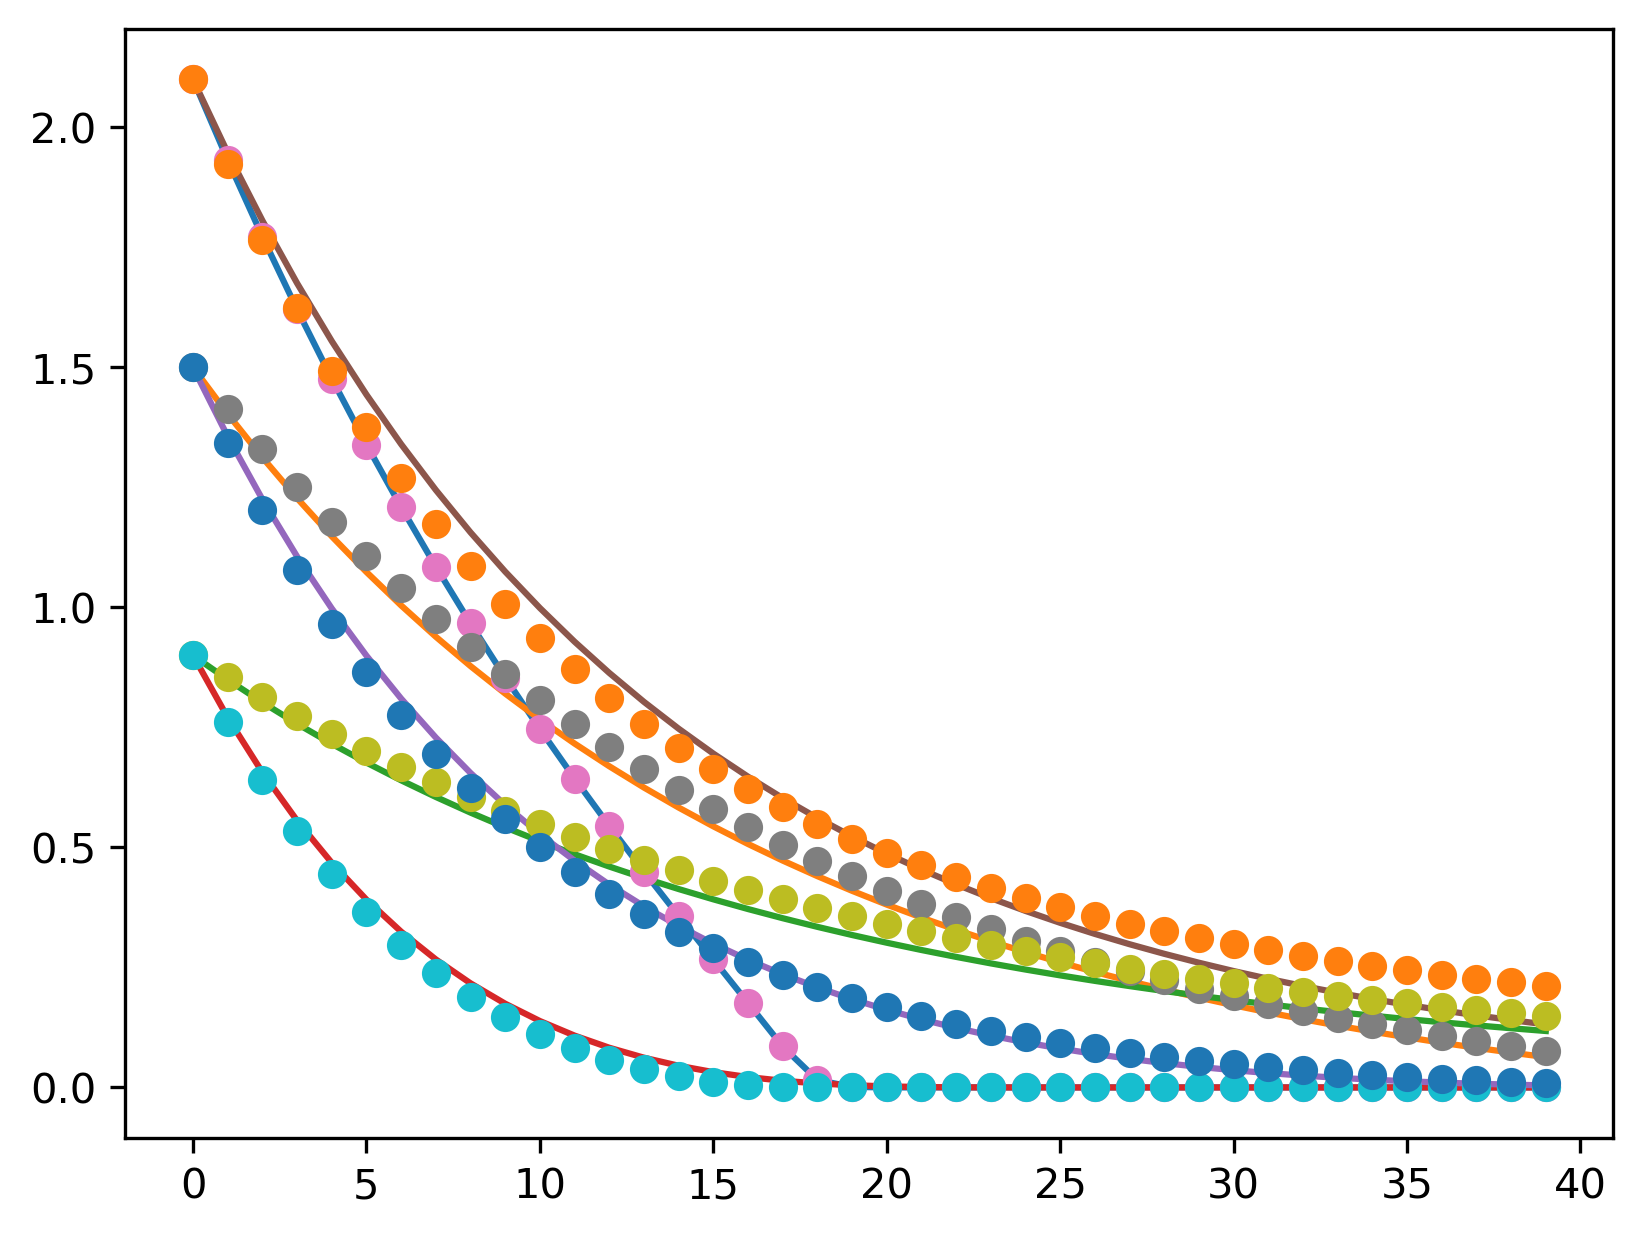

In [9]:
true_results = model(t, **k_params)
fitted_results = model(t, **final_params)

plt.figure(dpi=300)
plt.plot(true_results[0:num_points])
plt.plot(fitted_results[num_points:2*num_points])
plt.plot(fitted_results[2*num_points:3*num_points])
plt.plot(fitted_results[3*num_points:4*num_points])
plt.plot(fitted_results[4*num_points:5*num_points])
plt.plot(fitted_results[5*num_points:6*num_points])

plt.plot(true_results[0:num_points], 'o')
plt.plot(true_results[num_points:2*num_points], 'o')
plt.plot(true_results[2*num_points:3*num_points], 'o')
plt.plot(true_results[3*num_points:4*num_points], 'o')
plt.plot(true_results[4*num_points:5*num_points], 'o')
plt.plot(true_results[5*num_points:6*num_points], 'o')
